In [34]:
import re
import os
import time
import pickle
import sklearn
#import cx_Oracle
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.sparse
from tqdm import tqdm, tqdm_notebook
from sklearn import datasets
from collections import defaultdict
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, coo_matrix, csc_matrix


# oracle
#oracle_user = "ro_user"
#oracle_pass = "ro_user"
#oracle_scheme = "aml_evraz"
#oracle_host = "192.168.101.13/rnd"
#oracle_connection = cx_Oracle.connect(oracle_user, oracle_pass, oracle_host, encoding = "UTF-8", nencoding = "UTF-8")
#oracle_cursor = oracle_connection.cursor()

### PUT YOUR PATH HERE (mine default is home/username/notebooks)
path_to_data = '../../shared_files/'

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [118]:
def flatten_df_by_column(df, to_flatten, flatten_by, group_by, names_flatten_by=None):
    columns_to_flatten = to_flatten
    column_to_flatten_by = flatten_by
    column_to_group_by = group_by
    if names_flatten_by is None:
        names_flatten_by = {
            uniq_val: uniq_val
            for uniq_val in df[column_to_flatten_by].unique()
        }
    if not isinstance(columns_to_flatten, (list, tuple, pd.Index)):
        columns_to_flatten = [to_flatten]
    frames_to_join = [
        df[[column_to_group_by] + columns_to_flatten][df[column_to_flatten_by] == uniq_val]
        for uniq_val in df[column_to_flatten_by].unique()
    ]

    for frame, uniq_val in zip(frames_to_join, df[flatten_by].unique()):
        frame.set_index(column_to_group_by, inplace=True)
        frame.columns = pd.MultiIndex.from_product([[uniq_val], frame.columns], names=[column_to_flatten_by, 'columns'])

    res = frames_to_join[0].join(frames_to_join[1:], how='outer')
    return res


def join_ops_with_flatten_members(ops, flatten_ops_with_members, id_colname='ID', ops_columns_level_name=None):
    if ops_columns_level_name is None:
        ops_columns_level_name = str(list(flatten_ops_with_members.columns.levels[0]))
    ops_to_join = ops.set_index(id_colname, drop=False)
    ops_to_join.columns = pd.MultiIndex.from_product([[ops_columns_level_name], ops_to_join.columns],
                                                     names=flatten_ops_with_members.columns.names)
    joined_ops = ops_to_join.join(flatten_ops_with_members, how='left')
    joined_ops.reset_index(drop=True, inplace=True)
    return joined_ops

In [98]:
names_by_clientrole = {
    1: 'sourc',
    2: 'target',
    3: 'id_susp_3',
    4: 'id_susp_4',
    5: 'beneficial',
    6: 'id_susp_6'
}


with Timer('building flatten selected members'):
    selected_members_flatten = flatten_df_by_column(
        off_members_selected,
        to_flatten=[
           'P_CLIENTID',
           'P_REGOPENDATE',
           'P_COUNTRYCODE',
           'P_BANKCITY',
           'P_BANK',
           'P_BANK_CLIENT',
           'P_CLIENT_TYPE',
            'seconds_from_start',
            'seconds_from_last_client_op'],
        flatten_by='P_CLIENTROLE',
        group_by='P_OPERATIONID',
        names_flatten_by=names_by_clientrole)

building flatten selected members took 13.352s


In [101]:
selected_members_flatten.head(10)

P_CLIENTROLE           1                                                   \
columns       P_CLIENTID P_REGOPENDATE P_COUNTRYCODE P_BANKCITY    P_BANK   
P_OPERATIONID                                                               
0                    0.0           NaT            KZ  г. Алматы  EURIKZKA   
1                    2.0           NaT            KZ  г. Алматы  EURIKZKA   
2                    3.0           NaT            KZ  г. Алматы  EURIKZKA   
3                    4.0           NaT            KZ  г. Алматы  EURIKZKA   
4                    NaN           NaT           NaN        NaN       NaN   
5                    NaN           NaT           NaN        NaN       NaN   
6                    NaN           NaT           NaN        NaN       NaN   
7                    NaN           NaT           NaN        NaN       NaN   
8                    NaN           NaT           NaN        NaN       NaN   
9                    NaN           NaT           NaN        NaN       NaN   

P_CLIENTROLE                                                  \
columns       P_BANK_CLIENT P_CLIENT_TYPE seconds_from_start   
P_OPERATIONID                                                  
0                       2.0           2.0                0.0   
1                       2.0           2.0                0.0   
2                       2.0           2.0                0.0   
3                       2.0           2.0                0.0   
4                       NaN           NaN                NaN   
5                       NaN           NaN                NaN   
6                       NaN           NaN                NaN   
7                       NaN           NaN                NaN   
8                       NaN           NaN                NaN   
9                       NaN           NaN                NaN   

P_CLIENTROLE                                       2  \
columns       seconds_from_last_client_op P_CLIENTID   
P_OPERATIONID                                          
0                               -100000.0        1.0   
1                               -100000.0        1.0   
2                               -100000.0        1.0   
3                               -100000.0        1.0   
4                                     NaN        5.0   
5                                     NaN        6.0   
6                                     NaN        7.0   
7                                     NaN        8.0   
8                                     NaN        8.0   
9                                     NaN        8.0   

P_CLIENTROLE              ...                                          \
columns                   ...             seconds_from_last_client_op   
P_OPERATIONID             ...                                           
0                         ...                               -100000.0   
1                         ...                                     0.0   
2                         ...                                     0.0   
3                         ...                                     0.0   
4                         ...                               -100000.0   
5                         ...                               -100000.0   
6                         ...                               -100000.0   
7                         ...                               -100000.0   
8                         ...                                   120.0   
9                         ...                                   240.0   

P_CLIENTROLE           5                                                \
columns       P_CLIENTID P_REGOPENDATE P_COUNTRYCODE P_BANKCITY P_BANK   
P_OPERATIONID                                                            
0                    NaN           NaT           NaN        NaN    NaN   
1                    NaN           NaT           NaN        NaN    NaN   
2                    NaN           NaT           NaN        NaN    NaN   
3                    NaN           NaT    

In [119]:
with Timer('join offline operations with selected member columns'):
    joined_kek = join_ops_with_flatten_members(off_ops, selected_members_flatten, ops_columns_level_name='all')

join offline operations with selected member columns took 7.118s


In [ ]:
pd.MultiIndex.from_product([['Kek'], ['kek', 'pek']], names=['P_CLIENTROLE', 'columns'])

In [90]:
kek_members = off_members[off_members.P_CLIENTROLE == 1].copy()

In [91]:
kek_members.set_index('P_OPERATIONID', drop=False, inplace=True)

In [92]:
kek_members.columns = pd.MultiIndex.from_product([[1], kek_members.columns], names=['P_CLIENTROLE', 'columns'])

In [93]:
kek_members.head(5)

P_CLIENTROLE           1                                                      \
columns               ID P_OPERATIONID P_CLIENTID P_BSCLIENTID P_BANK_CLIENT   
P_OPERATIONID                                                                  
0              528657551             0          0  9.45527e+08             2   
1              528657554             1          2  9.43723e+08             2   
2              528657557             2          3  3.96309e+07             2   
3              528657560             3          4  4.13599e+07             2   
13             528660317            13         12   9.5803e+07             2   

P_CLIENTROLE                                                                 \
columns              P_REGOPENDATE P_COUNTRYCODE P_CLIENT_TYPE P_CLIENTROLE   
P_OPERATIONID                                                                 
0              0000-00-00 00:00:00            KZ             2            1   
1              0000-00-00 00:00:00            KZ             2            1   
2              0000-00-00 00:00:00            KZ             2            1   
3              0000-00-00 00:00:00            KZ             2            1   
13             0000-00-00 00:00:00            KZ             2            1   

P_CLIENTROLE                           ...                                   \
columns       P_CLIENTKIND             ...                       P_BANKNAME   
P_OPERATIONID                          ...                                    
0                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
1                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
2                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
3                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
13                      29             ...              АО ЕВРАЗИЙСКИЙ БАНК   

P_CLIENTROLE                                                  \
columns       P_IPDL P_USERNAME   P_SDP P_ORGFORM P_BANKCITY   
P_OPERATIONID                                                  
0                  1     LOADER -1000.0   -1000.0  г. Алматы   
1                  1     LOADER -1000.0   -1000.0  г. Алматы   
2                  1     LOADER -1000.0   -1000.0  г. Алматы   
3                  1     LOADER -1000.0   -1000.0  г. Алматы   
13                 1     LOADER -1000.0   -1000.0    ХРОМТАУ   

P_CLIENTROLE                                                                \
columns                P_OPER_DATE      P_OPERATIONDATE seconds_from_start   
P_OPERATIONID                                                                
0              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
1              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
2              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
3              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
13             2017-01-01 13:09:00  2017-01-01 00:00:00            47340.0   

P_CLIENTROLE                               
columns       seconds_from_last_client_op  
P_OPERATIONID                              
0                               -100000.0  
1                               -100000.0  
2                               -100000.0  
3                               -100000.0  
13                              -100000.0  

[5 rows x 24 columns]

In [94]:
kek_members.columns

MultiIndex(levels=[[1], ['ID', 'P_ACCOUNT', 'P_BANK', 'P_BANKCITY', 'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_BANK_CLIENT', 'P_BSACCOUNT', 'P_BSCLIENTID', 'P_CLIENTID', 'P_CLIENTKIND', 'P_CLIENTROLE', 'P_CLIENT_TYPE', 'P_COUNTRYCODE', 'P_IPDL', 'P_OPERATIONDATE', 'P_OPERATIONID', 'P_OPER_DATE', 'P_ORGFORM', 'P_REGOPENDATE', 'P_SDP', 'P_USERNAME', 'seconds_from_last_client_op', 'seconds_from_start']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 16, 9, 8, 6, 19, 13, 12, 11, 10, 1, 7, 2, 4, 5, 14, 21, 20, 18, 3, 17, 15, 23, 22]],
           names=['P_CLIENTROLE', 'columns'])

In [95]:
pek_members = off_members[off_members.P_CLIENTROLE == 2].copy()
pek_members.set_index('P_OPERATIONID', drop=False, inplace=True)
pek_members.columns = pd.MultiIndex.from_product([[2], pek_members.columns], names=['P_CLIENTROLE', 'columns'])

In [96]:
pek_members.head(5)

P_CLIENTROLE           2                                                      \
columns               ID P_OPERATIONID P_CLIENTID P_BSCLIENTID P_BANK_CLIENT   
P_OPERATIONID                                                                  
0              528657552             0          1   9.5024e+11             2   
1              528657555             1          1   9.5024e+11             2   
2              528657558             2          1   9.5024e+11             2   
3              528657562             3          1   9.5024e+11             2   
4              528659891             4          5  9.64565e+07             2   

P_CLIENTROLE                                                                 \
columns              P_REGOPENDATE P_COUNTRYCODE P_CLIENT_TYPE P_CLIENTROLE   
P_OPERATIONID                                                                 
0              0000-00-00 00:00:00            KZ             1            2   
1              0000-00-00 00:00:00            KZ             1            2   
2              0000-00-00 00:00:00            KZ             1            2   
3              0000-00-00 00:00:00            KZ             1            2   
4              0000-00-00 00:00:00            KZ             2            2   

P_CLIENTROLE                           ...                                   \
columns       P_CLIENTKIND             ...                       P_BANKNAME   
P_OPERATIONID                          ...                                    
0                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
1                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
2                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
3                       55             ...              АО ЕВРАЗИЙСКИЙ БАНК   
4                       29             ...              АО ЕВРАЗИЙСКИЙ БАНК   

P_CLIENTROLE                                                  \
columns       P_IPDL P_USERNAME   P_SDP P_ORGFORM P_BANKCITY   
P_OPERATIONID                                                  
0                  1     LOADER -1000.0      28.0  г. Алматы   
1                  1     LOADER -1000.0      28.0  г. Алматы   
2                  1     LOADER -1000.0      28.0  г. Алматы   
3                  1     LOADER -1000.0      28.0  г. Алматы   
4                  1     LOADER -1000.0   -1000.0  КЫЗЫЛОРДА   

P_CLIENTROLE                                                                \
columns                P_OPER_DATE      P_OPERATIONDATE seconds_from_start   
P_OPERATIONID                                                                
0              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
1              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
2              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
3              2017-01-01 00:00:00  2017-01-01 00:00:00                0.0   
4              2017-01-01 02:10:00  2017-01-01 00:00:00             7800.0   

P_CLIENTROLE                               
columns       seconds_from_last_client_op  
P_OPERATIONID                              
0                               -100000.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                               -100000.0  

[5 rows x 24 columns]

In [89]:
kek_members.set_index[]

Int64Index([       0,        2,        4,        6,       17,       18,
                  19,       20,       21,       22,
            ...
            11514327, 11514329, 11514331, 11514333, 11514335, 11514337,
            11514339, 11514342, 11514343, 11514345],
           dtype='int64', length=7126911)

MultiIndex(levels=[['Kek'], ['kek', 'pek']],
           labels=[[0, 0], [0, 1]],
           names=['P_CLIENTROLE', 'columns'])

### Timer, table stat function, P_CLIENTID clearing procedure, function for flattening dataframe by cat column

In [67]:
class Timer:
    def __init__(self, msg='operation', verbose=True):
        self.msg = msg
        self.verbose = verbose       
    def __enter__(self, ):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        if self.verbose:
            print('{} took {:.3f}s'.format(self.msg, self.interval), flush=True)


def df_categorical_variables_stat(df, max_cardinality=200):
    for colname in df.columns:
        print('next_column: {}'.format(colname))
        uniq_vals = df[colname].unique()
        nunique = len(uniq_vals)
        print("# of uniqs: {}".format(nunique))
        if nunique < max_cardinality:
            print('Viable Categorical. Value counts:')
            print(df[colname].value_counts(dropna=False))
        else:
            print('High cardinality/Non categorical')
        print((('-' * 80) + '\n')*3)


def process_client_indices(client_indices, trivial_to_nontrivial=None, default_null=-1000):
    if trivial_to_nontrivial is None:
        trivial_ids_to_nontrivial = defaultdict(lambda: -len(trivial_ids_to_nontrivial) - 2)

    nontrivial_clients_ids = client_indices.copy()
    nontrivial_clients_ids[nontrivial_clients_ids.isnull()] = default_null

    nontrivial_clients_ids = nontrivial_clients_ids.map(str)

    nontrivial_ids = nontrivial_clients_ids.map(lambda s: s.strip())

    is_trivial = nontrivial_ids.map(lambda s: len(re.findall('^([\d]+|-[\d]+)', s)) == 0)
    trivial_ids = nontrivial_ids[is_trivial]

    for ti in trivial_ids:
        trivial_ids_to_nontrivial[ti]
    trivial_ids_to_nontrivial
    nontrivial_ids[is_trivial] = trivial_ids.map(lambda s: str(trivial_ids_to_nontrivial[s]))

    nontrivial_ids = nontrivial_ids.map(lambda s: re.findall('^([\d]+|-[\d]+)', s)[0]).map(int)
    return nontrivial_ids, trivial_to_nontrivial


def flatten_by_column(df, to_flatten, flatten_by, group_by, names_flatten_by=None):
    if names_flatten_by is None:
        names_flatten_by = {
            uniq_val: '{}={}'.format(flatten_by, uniq_val)
            for uniq_val in df[flatten_by].unique()
        }
    #column_to_flatten_by = 'P_CLIENTROLE'
    #column_to_group_by = 'P_SUSPICIOUSOPERATIONID'
    #column_to_flatten = 'P_CLIENTID'
    column_to_flatten_by = flatten_by
    column_to_flatten = to_flatten
    column_to_group_by = group_by
    frames_to_join = [
        df[[column_to_group_by, column_to_flatten]][df[column_to_flatten_by] == uniq_val]
        for uniq_val in df[column_to_flatten_by].unique()
    ]

    for frame, uniq_val in zip(frames_to_join, df[flatten_by].unique()):
        frame.rename(columns={column_to_flatten: names_flatten_by[uniq_val]}, inplace=True)
        frame.set_index(column_to_group_by, inplace=True)

    res = frames_to_join[0].join(frames_to_join[1:], how='outer')
    return res


def flatten_df_by_column(df, to_flatten, flatten_by, group_by, names_flatten_by=None):
    if names_flatten_by is None:
        names_flatten_by = {
            uniq_val: '{}={}'.format(flatten_by, uniq_val)
            for uniq_val in df[flatten_by].unique()
        }
    #column_to_flatten_by = 'P_CLIENTROLE'
    #column_to_group_by = 'P_SUSPICIOUSOPERATIONID'
    #column_to_flatten = 'P_CLIENTID'
    column_to_flatten_by = flatten_by
    columns_to_flatten = to_flatten
    if not isinstance(columns_to_flatten, (list, tuple, pd.Index)):
        columns_to_flatten = [to_flatten]
    column_to_group_by = group_by
    frames_to_join = [
        df[[column_to_group_by] + columns_to_flatten][df[column_to_flatten_by] == uniq_val]
        for uniq_val in df[column_to_flatten_by].unique()
    ]

    for frame, uniq_val in zip(frames_to_join, df[flatten_by].unique()):
        frame.rename(
            columns = {
                column_to_flatten: '{}__{}'.format(column_to_flatten, names_flatten_by[uniq_val])
                for column_to_flatten in columns_to_flatten
            },
            inplace=True)
        frame.set_index(column_to_group_by, inplace=True)

    res = frames_to_join[0].join(frames_to_join[1:], how='outer')
    return res


def join_ops_with_flatten_members(ops, flatten_ops_with_members, id_colname='ID'):
    ops_to_join = ops.set_index(id_colname, drop=False)
    joined_ops = ops_to_join.join(flatten_ops_with_members, how='left')
    joined_ops.reset_index(drop=True, inplace=True)
    return joined_ops

### Read data csv and drop some columns and rows from off_members

In [3]:
with Timer('read susp_ops', True):
    susp_ops = pd.read_csv(os.path.join(path_to_data, 'susp_ops.csv'))
with Timer('read susp_members', True):
    susp_members = pd.read_csv(os.path.join(path_to_data, 'susp_members.csv'))
with Timer('read off_ops', True):
    off_ops = pd.read_csv(os.path.join(path_to_data, 'off_ops.csv'))
with Timer('read off_ops', True):
    off_members = pd.read_csv(os.path.join(path_to_data, 'off_members.csv'))

with Timer('drop messy off_members columns'):
    off_members.drop(['P_DATE_INSERT', 'P_DATE_UPDATE', 'CHANGEDATE'], axis=1, inplace=True)

with Timer('drop off_members with OPERATIONID that are not in off_ops'):
    off_members = off_members[off_members.P_OPERATIONID.isin(off_ops.ID)].copy()

with Timer('drop off_ops with OPERATIONID that are not in off_ops'):
    off_ops = off_ops[off_ops.ID.isin(off_members.P_OPERATIONID)].copy()

read susp_ops took 6.149s


/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,9,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read susp_members took 5.497s


/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,8,9,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read off_ops took 68.418s


/home/const.belev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,5,11,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read off_ops took 62.216s
drop messy off_members columns took 2.838s
drop off_members with OPERATIONID that are not in off_ops took 10.336s
drop off_ops with OPERATIONID that are not in off_ops took 8.831s


### Clean mess with P_CLIENTID and columns containing nans, drop stupid duplicates

In [4]:
fill_values_for_off_members = {
    'P_BSCLIENTID': -1000,
    'P_REGOPENDATE': '0000-00-00 00:00:00',
    'P_BSACCOUNT': -1000,
    'P_BANK': 'UNKNOWN',
    'P_SDP': -1000,
    'P_ORGFORM': -1000,
    'P_BANKCITY': 'UNKNOWN'
}

with Timer('filling NaNs in off_members'):
    off_members.fillna(value=fill_values_for_off_members, inplace=True)

with Timer('off_members client_ids processing'):
    off_members.loc[:, 'P_CLIENTID'], trivial_ids_to_nontrivial = process_client_indices(off_members.P_CLIENTID)

with Timer('dropping duplicate rows from off_members'):
    off_members.drop_duplicates(off_members.columns.drop(['ID', 'P_BSCLIENTID', 'P_BSACCOUNT']), inplace=True)

filling NaNs in off_members took 2.720s
off_members client_ids processing took 49.993s
dropping duplicate rows from off_members took 33.030s


### Convert time to datetime format and sort operations by time

In [5]:
with Timer('process off_ops', True):
    off_ops.loc[:, 'P_OPERATIONDATETIME'] = pd.to_datetime(off_ops['P_OPERATIONDATETIME'])
    off_ops.sort_values(by='P_OPERATIONDATETIME', kind='mergesort', inplace=True)

process off_ops took 8.011s


### Map operation ID to 0-based one (assuming our ops already sorted)

In [6]:
with Timer('building counters for unique operation ID'):
    operation_id_uniqs, operation_id_indices = np.unique(off_ops.ID.values, return_index=True)
    operation_id_uniqs = operation_id_uniqs[operation_id_indices.argsort()]
    operationid_counter = {u: i for i, u in enumerate(operation_id_uniqs)}
    operationid_inv_counter = {v: k for k, v in operationid_counter.items()}

%reset_selective -f operation_id_uniqs
%reset_selective -f operation_id_indices

with Timer('mapping original ID to 0-based for off_ops'):
    off_ops.loc[:, 'ID'] = off_ops['ID'].map(operationid_counter.get)

with Timer('mapping original P_OPERATIONID to 0-based for off_members'):
    off_members.loc[:, 'P_OPERATIONID'] = off_members['P_OPERATIONID'].map(operationid_counter.get)

building counters for unique operation ID took 7.622s
mapping original ID to 0-based for off_ops took 5.729s
mapping original P_OPERATIONID to 0-based for off_members took 10.335s


### Map P_CLIENTID to 0-based indices (to be able to work with sparse client matrices)

In [7]:
with Timer('sort off-members by time-sorted operation ID'):
    off_members.sort_values('P_OPERATIONID', kind='mergesort', inplace=True)

clientids_sorted = off_members['P_CLIENTID'].values

with Timer('build fast uniqs'):
    clientids_uniqs, clientids_indices = np.unique(clientids_sorted[np.isfinite(clientids_sorted)], return_index=True)
    clientids_uniqs = clientids_uniqs[clientids_indices.argsort()]

with Timer('build clientid_counter'):
    clientid_counter = {u: i for i, u in enumerate(clientids_uniqs)}
    clientid_inv_counter = {v: k for k, v in clientid_counter.items()}

with Timer('mapping original P_CLIENTID to 0-based for off_members'):
    off_members.loc[:, 'P_CLIENTID'] = off_members['P_CLIENTID'].map(clientid_counter.get)

sort off-members by time-sorted operation ID took 8.393s
build fast uniqs took 9.177s
build clientid_counter took 0.588s
mapping original P_CLIENTID to 0-based for off_members took 11.684s


In [8]:
with Timer('calculate seconds from start for off_ops'):
    off_ops['seconds_from_start'] = (off_ops.P_OPERATIONDATETIME - \
                                                off_ops.P_OPERATIONDATETIME.min()).dt.total_seconds()

calculate seconds from start for off_ops took 1.768s


In [25]:
off_members.reset_index(drop=True, inplace=True)
off_ops.reset_index(drop=True, inplace=True)

In [26]:
with Timer('join off_members and seconds_from_start from off_ops'):
    off_members = off_members.merge(off_ops[['ID', 'seconds_from_start']], how='inner', left_on='P_OPERATIONID', right_on='ID')
    off_members.drop(['ID_y'], axis=1, inplace=True)
    off_members.rename(columns={'ID_x': 'ID'}, inplace=True)

join off_members and seconds_from_start from off_ops took 36.750s


In [ ]:
with Timer('stable sorting off_members by P_CLIENTID inplace'):
    off_members.sort_values('P_CLIENTID', kind='mergesort', inplace=True)

with Timer('retrieve deltas between client current and last operation'):
    off_members['seconds_from_last_client_op'] = off_members.groupby('P_CLIENTID')['seconds_from_start']\
                .agg('diff')\
                .sort_index(kind='mergesort')\
                .fillna(-100000)

In [37]:
with Timer('sort back off_members by P_OPERATIONID'):
    off_members.sort_values('P_OPERATIONID', kind='mergesort', inplace=True)

sort back off_members by P_OPERATIONID took 17.558s


In [43]:
off_members.head(10)

,ID,P_OPERATIONID,P_CLIENTID,P_BSCLIENTID,P_BANK_CLIENT,P_REGOPENDATE,P_COUNTRYCODE,P_CLIENT_TYPE,P_CLIENTROLE,P_CLIENTKIND,...,P_BANKNAME,P_IPDL,P_USERNAME,P_SDP,P_ORGFORM,P_BANKCITY,P_OPER_DATE,P_OPERATIONDATE,seconds_from_start,seconds_from_last_client_op
0,528657551,0,0,9.45527e+08,2,0000-00-00 00:00:00,KZ,2,1,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,-1000.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,-100000.0
1,528657552,0,1,9.5024e+11,2,0000-00-00 00:00:00,KZ,1,2,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,28.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,-100000.0
3,528657555,1,1,9.5024e+11,2,0000-00-00 00:00:00,KZ,1,2,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,28.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,0.0
2,528657554,1,2,9.43723e+08,2,0000-00-00 00:00:00,KZ,2,1,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,-1000.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,-100000.0
5,528657558,2,1,9.5024e+11,2,0000-00-00 00:00:00,KZ,1,2,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,28.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,0.0
4,528657557,2,3,3.96309e+07,2,0000-00-00 00:00:00,KZ,2,1,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,-1000.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,-100000.0
7,528657562,3,1,9.5024e+11,2,0000-00-00 00:00:00,KZ,1,2,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,28.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,0.0
6,528657560,3,4,4.13599e+07,2,0000-00-00 00:00:00,KZ,2,1,55,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,-1000.0,г. Алматы,2017-01-01 00:00:00,2017-01-01 00:00:00,0.0,-100000.0
8,528659891,4,5,9.64565e+07,2,0000-00-00 00:00:00,KZ,2,2,29,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,-1000.0,КЫЗЫЛОРДА,2017-01-01 02:10:00,2017-01-01 00:00:00,7800.0,-100000.0
9,528661045,5,6,9.63976e+07,2,0000-00-00 00:00:00,KZ,2,2,29,...,АО ЕВРАЗИЙСКИЙ БАНК,1,LOADER,-1000.0,-1000.0,КАПШАГАЙ,2017-01-01 10:58:00,2017-01-01 00:00:00,39480.0,-100000.0


In [64]:
with Timer('process selected fields from off_members'):
    # There are some weird dates in P_REGOPENDATE, raising errors will force them to be  NaT
    p_regopendate = pd.to_datetime(off_members.P_REGOPENDATE, errors='coerce', format='%Y-%m-%d %H:%M:%S')

    # Rare countrycodes would be set as 'UNFREQ', NaNs will be 'UNKNOWN'
    p_countrycode = off_members.P_COUNTRYCODE.copy()
    countrycode_counts = p_countrycode.value_counts()
    p_countrycode[p_countrycode.isin(countrycode_counts[countrycode_counts <= 100].index)] = 'UNFREQ'
    p_countrycode[p_countrycode.isnull()] = 'UNKNOWN'

    # Same for bankcity
    p_bankcity = off_members.P_BANKCITY.copy()
    bankcity_counts = p_bankcity.value_counts()
    p_bankcity[p_bankcity.isin(bankcity_counts[bankcity_counts <= 100].index)] = 'UNFREQ'
    p_bankcity[p_bankcity.isnull()] = 'UNKNOWN'

    # for bank there is only a few NaN values, so it will be 'UNFREQ' aswell
    p_bank = off_members.P_BANK.copy()
    bank_counts = p_bank.value_counts()
    p_bank[p_bank.isin(bank_counts[bank_counts <= 100].index)] = 'UNFREQ'
    p_bank[p_bank.isnull()] = 'UNFREQ'

    # SDP nas only NaN/13.0 values, so simply encode NaN with -1k
    p_sdp = off_members.P_SDP.copy()
    p_sdp[p_sdp.isnull()] = -1000

    # No missing values
    p_bank_client = off_members.P_BANK_CLIENT.copy()

    # No missing values
    p_client_type = off_members.P_CLIENT_TYPE.copy()

    # No missing values
    p_clientrole = off_members.P_CLIENTROLE.copy()
    p_seconds_from_start = off_members.seconds_from_start.copy()
    p_seconds_from_last_client_op = off_members.seconds_from_last_client_op.copy()

process selected fields from off_members took 16.846s


### Build new member info dataframe on top of processed columns


In [65]:
off_members_selected = off_members[['P_CLIENTID', 'P_OPERATIONID']].copy()
off_members_selected['P_REGOPENDATE'] = p_regopendate
off_members_selected['P_COUNTRYCODE'] = p_countrycode
off_members_selected['P_BANKCITY'] = p_bankcity
off_members_selected['P_BANK'] = p_bank
off_members_selected['P_BANK_CLIENT'] = p_bank_client
off_members_selected['P_CLIENT_TYPE'] = p_client_type
off_members_selected['P_CLIENTROLE'] = p_clientrole
off_members_selected['seconds_from_start'] = p_seconds_from_start
off_members_selected['seconds_from_last_client_op'] = p_seconds_from_last_client_op

%reset_selective -f p_regopendate
%reset_selective -f p_countrycode
%reset_selective -f p_bankcity
%reset_selective -f p_bank
%reset_selective -f p_sdp
%reset_selective -f p_bank_client
%reset_selective -f p_client_type
%reset_selective -f p_clientrole
%reset_selective -f countrycode_counts
%reset_selective -f bank_counts
%reset_selective -f p_seconds_from_start
%reset_selective -f p_seconds_from_last_client_op

### Now its time to flatten selected members grouped by P_OPERATIONID, based on a P_CLIENTROLE


In [ ]:
%reset_selective -f selected_members_flatten

names_by_clientrole = {
    1: 'source_role',
    2: 'target_role',
    3: 'id_susp_3',
    4: 'id_susp_4',
    5: 'beneficial_role',
    6: 'id_susp_6'
}


with Timer('building flatten selected members'):
    selected_members_flatten = flatten_df_by_column(
        off_members_selected,
        to_flatten=[
           'P_CLIENTID',
           'P_REGOPENDATE',
           'P_COUNTRYCODE',
           'P_BANKCITY',
           'P_BANK',
           'P_BANK_CLIENT',
           'P_CLIENT_TYPE',
            'seconds_from_start',
            'seconds_from_last_client_op'],
        flatten_by='P_CLIENTROLE',
        group_by='P_OPERATIONID',
        names_flatten_by=names_by_clientrole)

In [7]:
%reset_selective -f clientids_sorted
%reset_selective -f clientids_uniqs
%reset_selective -f clientids_indices

client_columns = ['P_CLIENTID__source_role', 'P_CLIENTID__target_role', 'P_CLIENTID__beneficial_role']


with Timer('get sorted client_ids'):
    clientids_sorted = joined_off_ops[client_columns].values.reshape(-1)

with Timer('build fast uniqs'):
    clientids_uniqs, clientids_indices = np.unique(clientids_sorted[np.isfinite(clientids_sorted)], return_index=True)
    clientids_uniqs = clientids_uniqs[clientids_indices.argsort()]

with Timer('build clientid_counter'):
    clientid_counter = {u: i for i, u in enumerate(clientids_uniqs)}
    clientid_inv_counter = {v: k for k, v in clientid_counter.items()}
    
%reset_selective -f clientids_sorted
%reset_selective -f clientids_uniqs
%reset_selective -f clientids_indices

get sorted client_ids took 0.000s


NameError: name 'joined_off_ops' is not defined

### Get some meaningful columns from off_members

In [9]:
%reset_selective -f p_regopendate
%reset_selective -f p_countrycode
%reset_selective -f p_bankcity
%reset_selective -f p_bank
%reset_selective -f p_sdp
%reset_selective -f p_bank_client
%reset_selective -f p_client_type
%reset_selective -f p_clientrole
%reset_selective -f countrycode_counts
%reset_selective -f bank_counts


with Timer('process selected fields from off_members'):
    # There are some weird dates in P_REGOPENDATE, raising errors will force them to be  NaT
    p_regopendate = pd.to_datetime(off_members.P_REGOPENDATE, errors='coerce', format='%Y-%m-%d %H:%M:%S')

    # Rare countrycodes would be set as 'UNFREQ', NaNs will be 'UNKNOWN'
    p_countrycode = off_members.P_COUNTRYCODE.copy()
    countrycode_counts = p_countrycode.value_counts()
    p_countrycode[p_countrycode.isin(countrycode_counts[countrycode_counts <= 100].index)] = 'UNFREQ'
    p_countrycode[p_countrycode.isnull()] = 'UNKNOWN'

    # Same for bankcity
    p_bankcity = off_members.P_BANKCITY.copy()
    bankcity_counts = p_bankcity.value_counts()
    p_bankcity[p_bankcity.isin(bankcity_counts[bankcity_counts <= 100].index)] = 'UNFREQ'
    p_bankcity[p_bankcity.isnull()] = 'UNKNOWN'

    # for bank there is only a few NaN values, so it will be 'UNFREQ' aswell
    p_bank = off_members.P_BANK.copy()
    bank_counts = p_bank.value_counts()
    p_bank[p_bank.isin(bank_counts[bank_counts <= 100].index)] = 'UNFREQ'
    p_bank[p_bank.isnull()] = 'UNFREQ'

    # SDP nas only NaN/13.0 values, so simply encode NaN with -1k
    p_sdp = off_members.P_SDP.copy()
    p_sdp[p_sdp.isnull()] = -1000

    # No missing values
    p_bank_client = off_members.P_BANK_CLIENT.copy()

    # No missing values
    p_client_type = off_members.P_CLIENT_TYPE.copy()

    # No missing values
    p_clientrole = off_members.P_CLIENTROLE.copy()

process selected fields from off_members took 15.623s


### Build new member info dataframe on top of processed columns


In [10]:
%reset_selective -f off_members_selected

off_members_selected = off_members[['P_CLIENTID', 'P_OPERATIONID']].copy()
off_members_selected['P_REGOPENDATE'] = p_regopendate
off_members_selected['P_COUNTRYCODE'] = p_countrycode
off_members_selected['P_BANKCITY'] = p_bankcity
off_members_selected['P_BANK'] = p_bank
off_members_selected['P_BANK_CLIENT'] = p_bank_client
off_members_selected['P_CLIENT_TYPE'] = p_client_type
off_members_selected['P_CLIENTROLE'] = p_clientrole

off_members_selected.head(3)

,P_CLIENTID,P_OPERATIONID,P_REGOPENDATE,P_COUNTRYCODE,P_BANKCITY,P_BANK,P_BANK_CLIENT,P_CLIENT_TYPE,P_CLIENTROLE
0,950240000112,529719567,NaT,KZ,АЛМАТЫ,190501948,2,3,1
1,950240000112,529719567,2003-09-02,KZ,АЛМАТЫ,EURIKZKA,2,1,2
2,950240000112,529722750,2003-09-02,KZ,АЛМАТЫ,190501948,2,1,1


### Now its time to flatten selected members grouped by P_OPERATIONID, based on a P_CLIENTROLE


In [11]:
%reset_selective -f selected_members_flatten

names_by_clientrole = {
    1: 'source_role',
    2: 'target_role',
    3: 'id_susp_3',
    4: 'id_susp_4',
    5: 'beneficial_role',
    6: 'id_susp_6'
}


with Timer('building flatten selected members'):
    selected_members_flatten = flatten_df_by_column(
        off_members_selected,
        to_flatten=[
           'P_CLIENTID',
           'P_REGOPENDATE',
           'P_COUNTRYCODE',
           'P_BANKCITY',
           'P_BANK',
           'P_BANK_CLIENT',
           'P_CLIENT_TYPE'],
        flatten_by='P_CLIENTROLE',
        group_by='P_OPERATIONID',
        names_flatten_by=names_by_clientrole)

building flatten selected members took 15.545s


In [12]:
%reset_selective -f joined_off_ops

with Timer('join offline operations with selected member columns'):
    joined_off_ops = join_ops_with_flatten_members(off_ops, selected_members_flatten)

join offline operations with selected member columns took 10.693s


### Map operation ID to 0-based one (assuming our ops already sorted)

In [13]:
with Timer('building counters for unique operation ID'):
    operation_id_uniqs, operation_id_indices = np.unique(joined_off_ops.ID.values, return_index=True)
    operation_id_uniqs = operation_id_uniqs[operation_id_indices.argsort()]
    operationid_counter = {u: i for i, u in enumerate(operation_id_uniqs)}
    operationid_inv_counter = {v: k for k, v in operationid_counter.items()}

%reset_selective -f operation_id_uniqs
%reset_selective -f operation_id_indices

with Timer('mapping original ID to 0-based for joined_off_ops'):
    joined_off_ops.loc[:, 'ID'] = joined_off_ops['ID'].map(operationid_counter.get)


building counters for unique operation ID took 6.970s
mapping original ID to 0-based for joined_off_ops took 13.239s


### Map P_CLIENTID to 0-based indices (to be able to work with sparse client matrices)

In [14]:
%reset_selective -f clientids_sorted
%reset_selective -f clientids_uniqs
%reset_selective -f clientids_indices

client_columns = ['P_CLIENTID__source_role', 'P_CLIENTID__target_role', 'P_CLIENTID__beneficial_role']


with Timer('get sorted client_ids'):
    clientids_sorted = joined_off_ops[client_columns].values.reshape(-1)

with Timer('build fast uniqs'):
    clientids_uniqs, clientids_indices = np.unique(clientids_sorted[np.isfinite(clientids_sorted)], return_index=True)
    clientids_uniqs = clientids_uniqs[clientids_indices.argsort()]

with Timer('build clientid_counter'):
    clientid_counter = {u: i for i, u in enumerate(clientids_uniqs)}
    clientid_inv_counter = {v: k for k, v in clientid_counter.items()}
    
%reset_selective -f clientids_sorted
%reset_selective -f clientids_uniqs
%reset_selective -f clientids_indices

get sorted client_ids took 0.291s
build fast uniqs took 3.258s
build clientid_counter took 0.599s


### map clients to a new indices, add seconds_from_start column


In [15]:
%reset_selective -f joined_off_ops['raw_id_source_role']
%reset_selective -f joined_off_ops['raw_id_target_role']
%reset_selective -f joined_off_ops['raw_id_beneficial_role']
%reset_selective -f joined_off_ops['seconds_from_start']

with Timer('map sender ids'):
    joined_off_ops['raw_id_source_role'] = joined_off_ops['P_CLIENTID__source_role'].map(clientid_counter.get)
with Timer('map owner ids'):
    joined_off_ops['raw_id_target_role'] = joined_off_ops['P_CLIENTID__target_role'].map(clientid_counter.get)
with Timer('map beneficial ids'):
    joined_off_ops['raw_id_beneficial_role'] = joined_off_ops['P_CLIENTID__beneficial_role'].map(clientid_counter.get)
with Timer('calculate seconds from start'):
    joined_off_ops['seconds_from_start'] = (joined_off_ops.P_OPERATIONDATETIME - \
                                                joined_off_ops.P_OPERATIONDATETIME.min()).dt.total_seconds()

map sender ids took 6.444s
map owner ids took 4.165s
map beneficial ids took 2.198s
calculate seconds from start took 1.728s


### Remove isolated susp_ops,  build target variable

In [16]:
susp_ops, _susp_ops = susp_ops[~susp_ops.P_OFFLINEOPERATIONID.isnull()].copy(), susp_ops
%reset_selective -f _susp_ops
susp_ops.loc[susp_ops.P_OPERATION_LIST.isnull(), 'P_OPERATION_LIST'] = ''

with Timer('setting proper labels for learning'):
    target_mapped = defaultdict(lambda: -1)

    for i, row in tqdm(susp_ops[['P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL']].iterrows(), total=len(susp_ops)):
        off_op_id, to_kfm = operationid_counter[int(row.P_OFFLINEOPERATIONID)], row.P_SENDTOKFMBOOL
        if off_op_id not in target_mapped:
            target_mapped[off_op_id] = 0 if to_kfm == 2 else 1
        else:
            cur_target = target_mapped[off_op_id]
            if cur_target == 0 and to_kfm != 2:
                target_mapped[off_op_id] = 1

with Timer('setting susp target for every operation'):
    joined_off_ops['target'] = joined_off_ops.ID.map(target_mapped.__getitem__)

100%|██████████| 401500/401500 [00:18<00:00, 22212.29it/s]

setting proper labels for learning took 18.302s


setting susp target for every operation took 4.347s


### Create graph dataframe for building some graph-based statistics

In [17]:
%reset_selective -f graph_trans_df

graph_trans_df = joined_off_ops[[
    'ID',
    'P_OPERATIONDATETIME',
    'seconds_from_start',
    'P_BASEAMOUNT',
    'raw_id_source_role',
    'raw_id_target_role',
    'raw_id_beneficial_role',
    'target'
]].copy()
#with Timer('writing graph_trans_df to disk'):
#    graph_trans_df.to_csv('graph_trans_df.csv', index=False)

In [15]:
#with Timer('writing graph_trans_df to disk'):
#    graph_trans_df.to_csv('graph_trans_df.csv', index=False)

### Take only direct transactions for feature sets simplicity (and because most fraudulent cases are in direct transactions)

In [18]:
joined_direct_trans = joined_off_ops[~joined_off_ops.raw_id_source_role.isnull() & ~joined_off_ops.raw_id_target_role.isnull() & joined_off_ops.raw_id_beneficial_role.isnull()].copy()
joined_direct_trans.drop([colname for colname in joined_direct_trans.columns if 'beneficial' in colname], axis=1, inplace=True)

In [19]:
{colname: joined_direct_trans[colname].isnull().mean() for colname in joined_direct_trans.columns}

{'CHANGEDATE': 0.0,
 'ID': 0.0,
 'P_BANKCITY__source_role': 0.0,
 'P_BANKCITY__target_role': 0.0,
 'P_BANKOPERATIONID': 0.0,
 'P_BANK_CLIENT__source_role': 0.0,
 'P_BANK_CLIENT__target_role': 0.0,
 'P_BANK__source_role': 0.0,
 'P_BANK__target_role': 0.0,
 'P_BASEAMOUNT': 0.0,
 'P_BRANCH': 0.0,
 'P_BS_OPER_TYPE': 0.0,
 'P_CLIENTID__source_role': 0.0,
 'P_CLIENTID__target_role': 0.0,
 'P_CLIENT_TYPE__source_role': 0.0,
 'P_CLIENT_TYPE__target_role': 0.0,
 'P_COUNTRYCODE__source_role': 0.0,
 'P_COUNTRYCODE__target_role': 0.0,
 'P_CURRENCYAMOUNT': 0.008116264527570019,
 'P_CURRENCYCODE': 0.0,
 'P_DATE_INSERT': 0.0,
 'P_DOCCATEGORY': 0.0,
 'P_DOCDATE': 0.0,
 'P_DOCNUMBER': 0.0,
 'P_EKNPCODE': 0.2851714973839382,
 'P_ISSUEDBID': 0.0,
 'P_KFM_OPER_REASON': 0.652598719082351,
 'P_OPERATIONDATE': 0.0,
 'P_OPERATIONDATETIME': 0.0,
 'P_OPERATIONREASON': 0.0,
 'P_ORIG_OPER_NUMBER': 0.0,
 'P_REGOPENDATE__source_role': 0.601071339589735,
 'P_REGOPENDATE__target_role': 0.5170724900706899,
 'P_TOEXTRA

In [20]:
joined_direct_trans['TIME_REG_DELTA__source_role'] = (joined_direct_trans.P_OPERATIONDATETIME - joined_direct_trans['P_REGOPENDATE__source_role']).dt.days
joined_direct_trans['TIME_REG_DELTA__target_role'] = (joined_direct_trans.P_OPERATIONDATETIME - joined_direct_trans['P_REGOPENDATE__target_role']).dt.days

docnumber_counts = joined_direct_trans.P_DOCNUMBER.value_counts()
joined_direct_trans.loc[joined_direct_trans.P_DOCNUMBER.isin(docnumber_counts[docnumber_counts <= 1000].index), 'P_DOCNUMBER'] = 'UNFREQ'

In [21]:
fillna_dict = {
    'P_EKNPCODE': -1000,
    'P_KFM_OPER_REASON': -1000,
    'TIME_REG_DELTA__target_role': -10000,
    'TIME_REG_DELTA__source_role': -10000,
}

In [22]:
allowed_columns = [
    'ID',
    'P_ISSUEDBID',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_BASEAMOUNT',
    'P_EKNPCODE',
    'P_DOCNUMBER',
    'P_DOCCATEGORY',
    'P_TOEXTRACTBOOL',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_WAS_SEND',
    'P_COUNTRYCODE__source_role',
    'P_BANKCITY__source_role',
    'P_BANK__source_role',
    'P_BANK_CLIENT__source_role',
    'P_CLIENT_TYPE__source_role',
    'P_COUNTRYCODE__target_role',
    'P_BANKCITY__target_role',
    'P_BANK__target_role',
    'P_BANK_CLIENT__target_role',
    'P_CLIENT_TYPE__target_role',
    'target',
    'TIME_REG_DELTA__target_role',
    'TIME_REG_DELTA__source_role'
]


columns_to_ohe = [
    'P_ISSUEDBID',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_EKNPCODE',
    'P_DOCNUMBER',
    'P_DOCCATEGORY',
    'P_TOEXTRACTBOOL',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_WAS_SEND',
    'P_COUNTRYCODE__source_role',
    'P_BANKCITY__source_role',
    'P_BANK__source_role',
    'P_BANK_CLIENT__source_role',
    'P_CLIENT_TYPE__source_role',
    'P_COUNTRYCODE__target_role',
    'P_BANKCITY__target_role',
    'P_BANK__target_role',
    'P_BANK_CLIENT__target_role',
    'P_CLIENT_TYPE__target_role',
]

In [23]:
%reset_selective -f nndf
nndf = joined_direct_trans[allowed_columns].copy()

In [24]:
%reset_selective -f links_week_info
links_week_info = pd.read_csv('links_week_info.csv')

In [25]:
len(links_week_info)

8222263

In [26]:
nndf = nndf.join(links_week_info.drop('ID', 1), how='left')

In [27]:
nndf.fillna(value=fillna_dict, inplace=True)

In [28]:
set(allowed_columns) - set(columns_to_ohe)

{'ID',
 'P_BASEAMOUNT',
 'TIME_REG_DELTA__source_role',
 'TIME_REG_DELTA__target_role',
 'target'}

In [29]:
nndfs_ohe = {colname: pd.get_dummies(nndf[[colname]], columns=[colname], prefix=[colname]) for colname in columns_to_ohe}

In [30]:
train_rate = 0.7
train_size = int(train_rate * len(nndf))

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca_ohe = {colname: PCA(n_components=max(1, int(np.sqrt(len(ohe_df.columns))))) for colname, ohe_df in nndfs_ohe.items()}

In [33]:
transformed_train_ohe = {}
transformed_test_ohe = {}

In [34]:
for colname in tqdm(columns_to_ohe):
    vals = nndfs_ohe[colname].values.astype(np.float32)
    transformed_train_ohe[colname] = pca_ohe[colname].fit_transform(vals[:train_size])
    transformed_test_ohe[colname] = pca_ohe[colname].transform(vals[train_size:])
    del vals

100%|██████████| 20/20 [04:03<00:00, 12.18s/it]


In [35]:
train_ohe = np.concatenate([transformed_train_ohe[colname] for colname in columns_to_ohe], axis=1)
test_ohe = np.concatenate([transformed_test_ohe[colname] for colname in columns_to_ohe], axis=1)

In [36]:
columns_to_non_ohe = [
    'P_BASEAMOUNT',
    'TIME_REG_DELTA__target_role',
    'TIME_REG_DELTA__target_role',
    'links_input_target',
    'links_input_source',
    'links_output_target',
    'links_output_source'
]

In [37]:
vals_non_ohe = nndf[columns_to_non_ohe].values.astype(np.float32)
train_non_ohe = vals_non_ohe[:train_size]
test_non_ohe = vals_non_ohe[train_size:]

In [38]:
%reset_selective -f xtrain
%reset_selective -f ytrain
%reset_selective -f xtest
%reset_selective -f ytest
xtrain, xtest = np.concatenate([train_ohe, train_non_ohe], axis=1), np.concatenate([test_ohe, test_non_ohe], axis=1)
ytrain, ytest = nndf.target.values[:train_size], nndf.target.values[train_size:]

In [39]:
with Timer('get operationid and clientid from off_members and map operationid and clientid to 0-based'):
    members = off_members[['P_OPERATIONID', 'P_CLIENTID']].copy()
    members.loc[:, 'P_OPERATIONID'] = members['P_OPERATIONID'].map(operationid_counter.get)
    members.loc[:, 'P_CLIENTID'] = members['P_CLIENTID'].map(clientid_counter.get)

with Timer('get seconds_from_start for each row in members'):
    members_seconds_from_start = joined_off_ops.seconds_from_start[members.P_OPERATIONID]
    members['seconds_from_start'] = members_seconds_from_start.values

%reset_selective -f members_seconds_from_start

get operationid and clientid from off_members and map operationid and clientid to 0-based took 21.647s
get seconds_from_start for each row in members took 137.916s


In [50]:
members_sorted = members.sort_values(['P_CLIENTID', 'P_OPERATIONID'], kind='mergesort')

In [59]:
sec_diff = members_sorted.groupby('P_CLIENTID')['seconds_from_start']\
            .agg('diff')\
            .sort_index(kind='mergesort')\
            .fillna(-100000)

In [ ]:
sec_diff_direct_trans = sec_diff[joined_direct_trans.index]

In [61]:
from sklearn.ensemble import IsolationForest

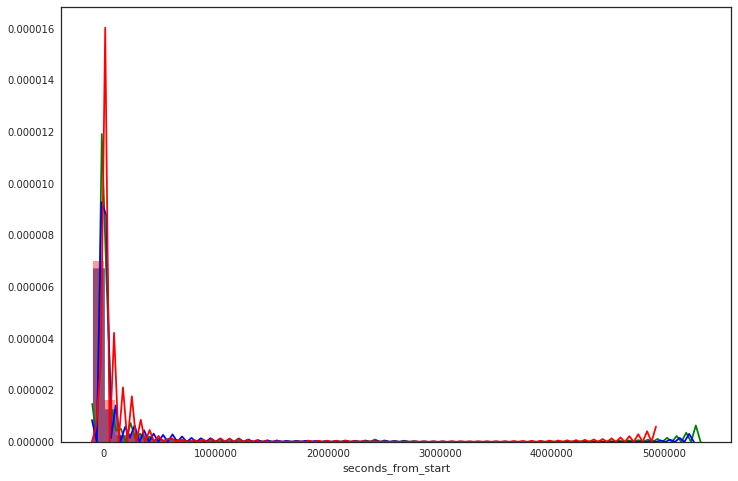

In [69]:
sns.distplot(sec_diff_direct_trans[nndf.target == -1], color='g')
sns.distplot(sec_diff_direct_trans[nndf.target == 0], color='b')
sns.distplot(sec_diff_direct_trans[nndf.target == 1], color='r')

In [ ]:
isof_time_to_prev_op = 

In [73]:
members_sorted['sec_diff'] = members_sorted.groupby('P_CLIENTID')['seconds_from_start'].agg('diff').fillna(-100000)

In [75]:
joined_off_ops.ID

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_CURRENCYAMOUNT', 'P_EKNPCODE',
       'P_DOCNUMBER', 'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'CHANGEDATE', 'P_KFM_OPER_REASON',
       'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER', 'P_WAS_SEND', 'P_OPERATIONDATE',
       'P_CLIENTID__source_role', 'P_REGOPENDATE__source_role',
       'P_COUNTRYCODE__source_role', 'P_BANKCITY__source_role',
       'P_BANK__source_role', 'P_BANK_CLIENT__source_role',
       'P_CLIENT_TYPE__source_role', 'P_CLIENTID__target_role',
       'P_REGOPENDATE__target_role', 'P_COUNTRYCODE__target_role',
       'P_BANKCITY__target_role', 'P_BANK__target_role',
       'P_BANK_CLIENT__target_role', 'P_CLIENT_TYPE__target_role',
       'P_CLIENTID__beneficial_role', 'P_REGOPENDATE__beneficial_role',
       'P_COUNTRYCODE__beneficial_role', 'P_BANKCITY__beneficial_role',
       'P_BANK__benefic

In [ ]:
joined_off_ops.ID

In [74]:
members_sorted

,P_OPERATIONID,P_CLIENTID,seconds_from_start,sec_diff
1699,0,0,0.0,-100000.0
1163395,950539,0,926877.0,926877.0
1700,0,1,0.0,-100000.0
1702,1,1,0.0,0.0
1704,2,1,0.0,0.0
1706,3,1,0.0,0.0
2514,1255,1,86400.0,86400.0
2516,1256,1,86400.0,0.0
2518,1257,1,86400.0,0.0
2520,1258,1,86400.0,0.0


In [37]:
from sklearn.ensemble import IsolationForest

In [38]:
isof = IsolationForest(contamination = (ytrain == 1).mean(), n_jobs=-1)

In [39]:
first_true_idx = np.where(joined_direct_trans.seconds_from_start > 7*86400)[0][0]

In [40]:
isof.fit(xtrain[first_true_idx:])

IsolationForest(bootstrap=False, contamination=0.010129956913660698,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
        random_state=None, verbose=0)

In [41]:
train_scores = isof.decision_function(xtrain[first_true_idx:])

In [42]:
test_scores = isof.decision_function(xtest)

In [43]:
train_pred = isof.predict(xtrain[first_true_idx:])

In [44]:
test_pred = isof.predict(xtest)

Text(0.5,1,'test scores')

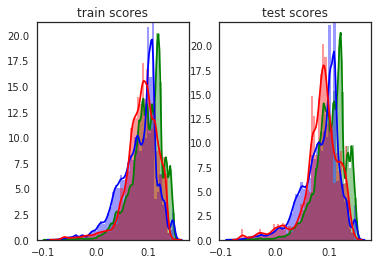

In [45]:
f, axes = plt.subplots(1, 2)
target_uniqs = [-1, 0, 1]
colors = ['g', 'b', 'r']
for tu, c in zip(target_uniqs, colors):
    sns.distplot(train_scores[ytrain[first_true_idx:] == tu], color=c, ax=axes[0])

for tu, c in zip(target_uniqs, colors):
    sns.distplot(test_scores[ytest == tu], color=c, ax=axes[1])
axes[0].set_title('train scores')
axes[1].set_title('test scores')

In [46]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [47]:
threshold = 0.07
ypred = np.array(test_scores <= threshold, dtype=int)
ytrue = np.array(ytest == 1, dtype=int)
confusion_matrix(ytrue, ypred)

array([[844707, 132944],
       [  3619,   1276]])

In [48]:
test_scores.min(), test_scores.max()

(-0.08469245322334873, 0.15412548997153175)

In [49]:
isof_graph = IsolationForest(contamination = (ytrain == 1).mean(), n_jobs=-1)

In [50]:
isof_graph.fit(xtrain[first_true_idx:, -4:])

IsolationForest(bootstrap=False, contamination=0.010129956913660698,
        max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
        random_state=None, verbose=0)

In [51]:
graph_train_scores = isof_graph.decision_function(xtrain[first_true_idx:, -4:])
graph_test_scores = isof_graph.decision_function(xtest[:, -4:])
graph_train_pred = isof_graph.predict(xtrain[first_true_idx:, -4:])
graph_test_pred = isof_graph.predict(xtest[:, -4:])

Text(0.5,1,'test scores')

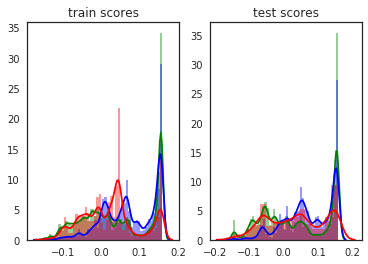

In [52]:
f, axes = plt.subplots(1, 2)
target_uniqs = [-1, 0, 1]
colors = ['g', 'b', 'r']
for tu, c in zip(target_uniqs, colors):
    sns.distplot(graph_train_scores[ytrain[first_true_idx:] == tu], color=c, ax=axes[0])

for tu, c in zip(target_uniqs, colors):
    sns.distplot(graph_test_scores[ytest == tu], color=c, ax=axes[1])
axes[0].set_title('train scores')
axes[1].set_title('test scores')

In [53]:
threshold = 0.1
graph_ypred = np.array(graph_test_scores <= threshold, dtype=int)
graph_ytrue = np.array(ytest == 1, dtype=int)
confusion_matrix(graph_ytrue, graph_ypred)

array([[350652, 626999],
       [  1425,   3470]])

In [54]:
joined_off_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_CURRENCYAMOUNT', 'P_EKNPCODE',
       'P_DOCNUMBER', 'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'CHANGEDATE', 'P_KFM_OPER_REASON',
       'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER', 'P_WAS_SEND', 'P_OPERATIONDATE',
       'P_CLIENTID__source_role', 'P_REGOPENDATE__source_role',
       'P_COUNTRYCODE__source_role', 'P_BANKCITY__source_role',
       'P_BANK__source_role', 'P_BANK_CLIENT__source_role',
       'P_CLIENT_TYPE__source_role', 'P_CLIENTID__target_role',
       'P_REGOPENDATE__target_role', 'P_COUNTRYCODE__target_role',
       'P_BANKCITY__target_role', 'P_BANK__target_role',
       'P_BANK_CLIENT__target_role', 'P_CLIENT_TYPE__target_role',
       'P_CLIENTID__beneficial_role', 'P_REGOPENDATE__beneficial_role',
       'P_COUNTRYCODE__beneficial_role', 'P_BANKCITY__beneficial_role',
       'P_BANK__benefic

In [55]:
off_members.columns

Index(['ID', 'P_OPERATIONID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_BANK_CLIENT',
       'P_REGOPENDATE', 'P_COUNTRYCODE', 'P_CLIENT_TYPE', 'P_CLIENTROLE',
       'P_CLIENTKIND', 'P_ACCOUNT', 'P_BSACCOUNT', 'P_BANK',
       'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_IPDL', 'P_USERNAME', 'P_SDP',
       'P_ORGFORM', 'P_BANKCITY', 'P_OPER_DATE', 'P_OPERATIONDATE'],
      dtype='object')

In [56]:
%reset_selective -f members
with Timer('get operationid and clientid from off_members and map operationid and clientid to 0-based'):
    members = off_members[['P_OPERATIONID', 'P_CLIENTID']].copy()
    members.loc[:, 'P_OPERATIONID'] = members['P_OPERATIONID'].map(operationid_counter.get)
    members.loc[:, 'P_CLIENTID'] = members['P_CLIENTID'].map(clientid_counter.get)

with Timer('get seconds_from_start for each row in members'):
    members_seconds_from_start = joined_off_ops.seconds_from_start[members.P_OPERATIONID]
    members['seconds_from_start'] = members_seconds_from_start.values

%reset_selective -f members_seconds_from_start

get operationid and clientid from off_members and map operationid and clientid to 0-based took 0.000s


NameError: name 'off_members' is not defined

In [2]:
kekes_pekes = 55
%reset_selective -f kekes
print(kekes_pekes)

NameError: name 'kekes_pekes' is not defined